# Validation of the PyPSA-Africa Electric Demand

This notebooks investigates the data quality of the African electric consumption
data by comparing PyPSA, official Nigerian and Our World in Data (incl. BP & Ember).

To reproduce the findings obtained in this notebook,
please run the full snakemake workflow for the Africa.
To do so, please set ``countries = ["Africa"]`` in the ``config.yaml`` file.

Note. An unoptimized prepared network is sufficient for this notebook. 

## Preparation

### Import packages

In [2]:
# import packages

import logging
import os

import pypsa
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

logger = logging.getLogger(__name__)

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 70)

In [3]:
red1 = '#891D2D'
red2 = '#BA3B31'
orange = '#F58221'
yellow = '#FCAF19'
brown = '#440A15'
purple1 = '#3B1053'
purple2 = '#76518E'
purple3 = '#B69DC7'
teal1 = '#032838'
teal2 = '#154655'
teal3 = '#527D77'
teal4 = '#8DB5AF'
green1 = '#294839'
green2 = '#6E966E'
green3 = '#A3BDA3'
beige1 = '#927F48'
beige2 = '#A89677'
beige3 = '#D2CDAD'

### Set main directory to root folder

In [4]:
# change current directory
import os
import sys

module_path = os.path.abspath(os.path.join('../../../')) # To import helpers
if module_path not in sys.path:
    sys.path.append(module_path+"/scripts")
    
from _helpers import sets_path_to_root, three_2_two_digits_country, two_2_three_digits_country

sets_path_to_root("pypsa-earth-project")

Cant find the repo path.


## 1. Load data 

#### Our World in Data
Retrieved from their GitHub: https://github.com/owid/energy-data/tree/master \
Web interface: https://ourworldindata.org/energy 

Our data sources:
- Energy consumption (primary energy, energy mix and energy intensity): this data is sourced from a combination of three sources—the BP Statistical Review of World Energy, the EIA and the SHIFT Data Portal.
- Electricity generation (electricity generation, and electricity mix): this data is sourced from a combination of three sources—the BP Statistical Review of World Energy, the Ember – Data Explorer and the Ember European Electricity Review.
- Other variables: this data is collected from a variety of sources (United Nations, World Bank, Gapminder, Maddison Project Database, etc.). More information is available in our codebook.


In [5]:
url = "https://nyc3.digitaloceanspaces.com/owid-public/data/energy/owid-energy-data.csv"
df = pd.read_csv("C:/Users/xenia/Desktop/Thesis_Code/Code/pypsa-earth_working/pypsa-earth/documentation/notebooks/validation/owid-energy-data.csv")
df = df.loc[:, ["iso_code", "country", "year", "electricity_demand"]]
df = df[df["iso_code"].notna()]  # removes antartica
#df["iso_code_2"] = df.loc[:, "iso_code"].apply(lambda x: three_2_two_digits_country(x))
electricity_demand_owid = df
electricity_demand_owid.tail(2)

,iso_code,country,year,electricity_demand
21888,ZWE,Zimbabwe,2020,9.58
21889,ZWE,Zimbabwe,2021,9.79


#### PyPSA network

Requires a solved or unsolved network.

In [8]:
solved_network_path = "C:/Users/xenia/Desktop/Thesis_Code/Code/pypsa-earth_working/pypsa-earth/networks/elec_s_4_ec.nc"
pypsa_network = pypsa.Network(solved_network_path)
electricity_demand_pypsa = pypsa_network.loads_t.p_set
electricity_demand_pypsa.sum(axis=1).max()

INFO:pypsa.io:Imported network elec_s_4_ec.nc has buses, carriers, generators, lines, links, loads, storage_units, stores


1444.7388390305268

# 2. Validate

#### Steps:
- Align country coverage of dataframe
- Pick year of interest for 'Our World in Data'
- Align dataframe naming and temporal resolution
- Merge dataframe


Reduce "Our World in Data" to contain the same countries as PyPSA

In [42]:
country_in_network = (
    electricity_demand_pypsa.columns.to_frame()["Load"].apply(lambda x: x[0:2]).values
)
#electricity_demand_owid_mini = electricity_demand_owid[
    #electricity_demand_owid["BOL"].isin(country_in_network)
#]

In [43]:
Bolivia_demand = electricity_demand_owid[electricity_demand_owid.iso_code =="BOL"]
Bolivia_demand_2021 = Bolivia_demand[Bolivia_demand.year ==2021]
Bolivia_demand_2021

,iso_code,country,year,electricity_demand
2654,BOL,Bolivia,2021,10.59


Create total electric demand in TWh from OWID for year of interest

In [44]:
year_owid = 2021  # option
df = Bolivia_demand_2021
df = df[df["year"] == year_owid]
electricity_demand_owid_mini = df
electricity_demand_owid_mini.head(2)

,iso_code,country,year,electricity_demand
2654,BOL,Bolivia,2021,10.59


Create total electric demand in TWh from PyPSA for chosen demand year in `config.yaml`

,0
Load,
BO 0,2.365509
BO 1,2.929574
BO 2,2.204671
BO 3,1.955308


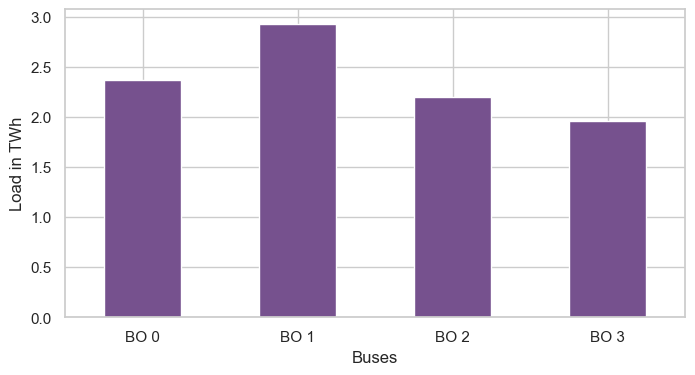

In [45]:
regional_demand = pd.DataFrame(electricity_demand_pypsa.sum()/1000000)
regional_demand.plot(kind='bar', legend=False, color=purple2,figsize=(8,4))
plt.xlabel('Buses')
plt.ylabel('Load in TWh')
plt.xticks(rotation = 0)

display(regional_demand)

#short the columns to only two digit (for groupby in next step)
electricity_demand_pypsa.columns = (
    electricity_demand_pypsa.columns.to_frame()["Load"].apply(lambda x: x[0:2]).values
)
#display(electricity_demand_pypsa)



Align PyPSA dataframe to 'Our World in Data'

In [46]:
import yaml

with open("C:/Users/xenia/Desktop/Thesis_Code/Code/pypsa-earth_working/pypsa-earth/config.yaml", "r") as file:
    config = yaml.safe_load(file)

df = electricity_demand_pypsa
#df.groupby()
df = pd.DataFrame(
    (df.sum().T.groupby([df.columns]).sum() / 10**6).round(6)
)  # MWh to TWh# 
display(df)
df = df.reset_index()
df = df.rename(columns={0: "electricity_demand", "index": "iso_code"})
df["year"] = config["load_options"]["prediction_year"]
df["iso_code"] = df.loc[:, "iso_code"].apply(lambda x: two_2_three_digits_country(x))

map_dic = pd.Series(
    electricity_demand_owid_mini.country.values,
    index=electricity_demand_owid_mini.iso_code,
).to_dict()
df["country"] = df["iso_code"].map(map_dic)
electricity_demand_pypsa = df
electricity_demand_pypsa.head(2)

,0
BO,9.45506


,iso_code,electricity_demand,year,country
0,BOL,9.45506,2030,Bolivia


Merge dataframes

In [36]:
h = config["load_options"]["prediction_year"]
electricity_demand_pypsa["source"] = f"PyPSA {h}"
electricity_demand_owid_mini["source"] = f"Our World in Data {year_owid}"
df_merge = pd.concat([electricity_demand_pypsa, electricity_demand_owid_mini])
df_merge

,iso_code,electricity_demand,year,country,source
0,BOL,9.4551,2030,Bolivia,PyPSA 2030
2654,BOL,10.5900,2021,Bolivia,Our World in Data 2021


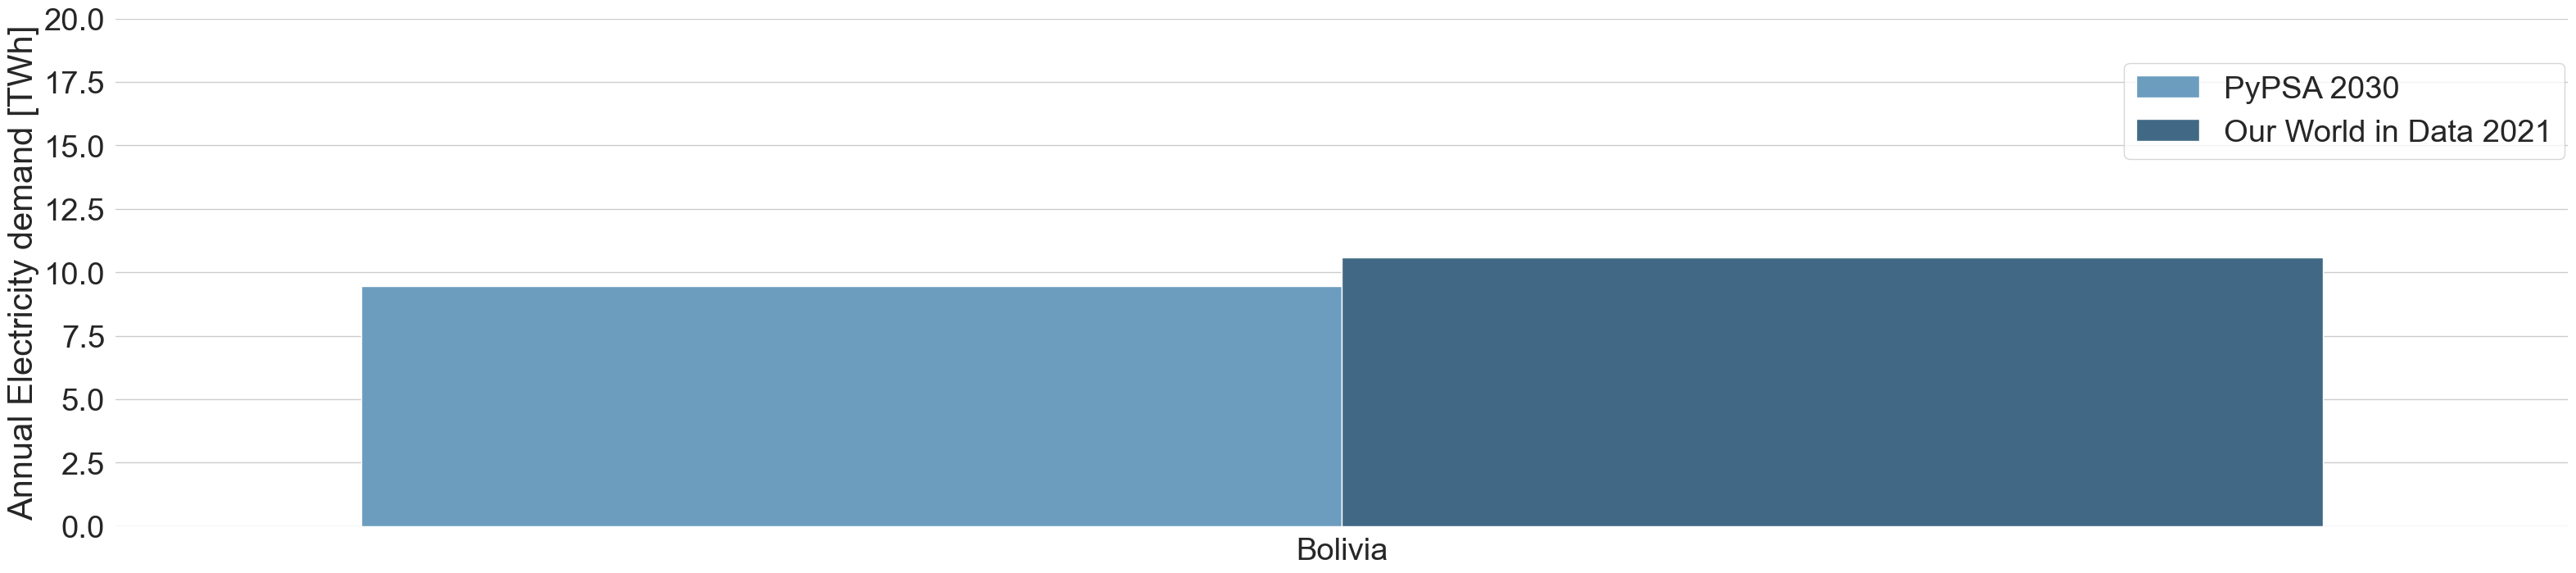

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.set_theme(style="whitegrid", font_scale=2.5)

# shorten names
df_merge.loc[df_merge["country"] == "Democratic Republic of Congo", "country"] = "DRC"
df_merge.loc[df_merge["country"] == "Central African Republic", "country"] = "CAR"

# split dataframe. No equal split possible since 'Our World in Data' misses "EH" == Western Sahara
df_merge1 = (
    df_merge.sort_values("country").iloc[0:46].sort_values("source", ascending=False)
)
df_merge2 = (
    df_merge.sort_values("country")
    .iloc[46:]
    .sort_values("source", ascending=False)
    .sort_values("country")
)

# Initialize the matplotlib figure
ax = sns.catplot(
    x="country",
    y="electricity_demand",
    hue="source",
    data=df_merge1,
    palette="Blues_d",
    kind="bar",
    height=8,
    aspect=4,
)
ax.set_xticklabels(rotation=0)
sns.move_legend(ax, "upper right", bbox_to_anchor=(0.85, 0.9), frameon=True, title=None)
sns.despine(left=True, bottom=True)
ax.set(xlabel=None, ylabel="Annual Electricity demand [TWh]", ylim=(0, 20))
ax.savefig("demand-validation-part1.pdf", bbox_inches="tight")

# ax = sns.catplot(
#    x="country",
#    y="electricity_demand",
#    hue="source",
#    data=df_merge2,
#    palette="Blues_d",
#    kind="bar",
#    height=8,
#    aspect=4,
#)
#ax.set_xticklabels(rotation=90)
#sns.move_legend(ax, "upper right", bbox_to_anchor=(0.85, 0.9), frameon=True, title=None)
#sns.despine(left=True, bottom=True)
#ax.set(xlabel=None, ylabel="Annual Electricity Demand [TWh]", ylim=(0, 500))
#ax.savefig("demand-validation-part2.pdf", bbox_inches="tight")


#sns.set_theme(style="whitegrid", font_scale=3.3)
#ax = sns.catplot(
#    x="country",
#    y="electricity_demand",
#    hue="source",
#    data=df_merge,
#    palette="Blues_d",
#    kind="bar",
#    height=8,
#    aspect=4,
#)

#ax.set_xticklabels(rotation=90)
#sns.move_legend(
#    ax, "upper right", bbox_to_anchor=(0.75, 0.94), frameon=True, title=None
#)
#sns.despine(left=True, bottom=False)
#ax.set(xlabel=None, ylabel="Electricity Demand [TWh/a]", ylim=(0, 500))
#ax.savefig("demand-validation-part.pdf", bbox_inches='tight')

C:\Users\xenia\AppData\Local\Temp\ipykernel_17300\4278182372.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_merge.groupby(by="source").sum().drop(columns="year").reset_index()


,source,electricity_demand
0,Our World in Data 2021,10.5900
1,PyPSA 2030,9.4551
0,IRENA 2030,1924.0000
1,Alova et al. 2030,1877.0000


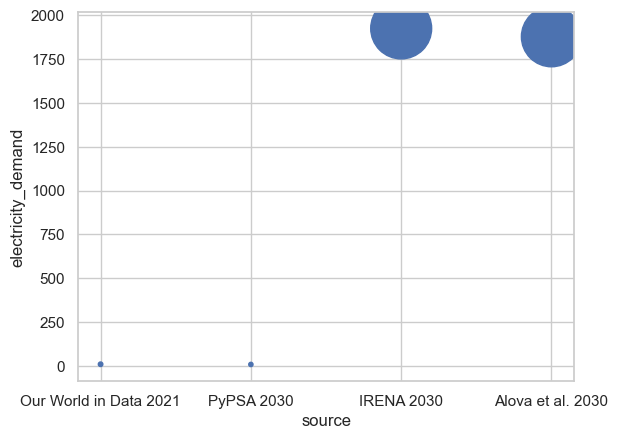

In [38]:
sns.set_theme(style="whitegrid", font_scale=1)

african_total_consumption = (
    df_merge.groupby(by="source").sum().drop(columns="year").reset_index()
)
extra = pd.DataFrame(
    data={
        "source": ["IRENA 2030", "Alova et al. 2030"],
        "electricity_demand": [1004 + 920, 1877],
    }
)
# https://www.irena.org/-/media/Files/IRENA/Agency/Publication/2015/IRENA_Africa_2030_REmap_2015_low-res.pdf
# https://www.nature.com/articles/s41560-020-00755-9

african_total_consumption = pd.concat([african_total_consumption, extra])
african_total_consumption.plot.scatter(
    x="source", y="electricity_demand", s="electricity_demand"
)
african_total_consumption